# Exploring Data
Initial exploration of the data: which items are missing, which cities are more reachable than others in radius, etc.

# Imports, Methods & Data
These are automatically executed using the initialisation-cells plugin.

In [102]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os.path
import utm
import numpy as np
import pandas as pd
import geopandas as gpd
from math import ceil
from pyproj import CRS

import seaborn as sns
sns.set()

import contextily as ctx
CTX_PROVIDER = ctx.providers.OpenStreetMap.Mapnik

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline

DROOT = './data/'
os.makedirs(os.path.join(DROOT, '5-graphs'), exist_ok=True)

/Users/ivo/opt/anaconda3/envs/thesis-env/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [103]:
def utm_epsg_from_latlot(lat, lon):
    zone = utm.from_latlon(lat, lon)[2]
    return f"326{zone:02d}" if lat >= 0 else f"327{zone:02d}"

def utm_epsg_from_point(point):
    return utm_epsg_from_latlot(point.y, point.x)


In [104]:
city_df = pd.read_csv(os.path.join(DROOT, '1-raw', 'citylist.csv'))
city_list_df = gpd.GeoDataFrame(
    city_df, crs=4326, 
    geometry=[Point(xy) for xy in zip(city_df.ctr_lon, city_df.ctr_lat)])

city_list_df.head(2)

,city,continent,order,country,ctr_name,ctr_lat,ctr_lon,cellsanalysed,geometry
0,Vienna,EUR,1,AUT,Rathaus Wien,48.21080,16.35784,4381.0,POINT (16.35784 48.21080)
1,Graz,EUR,2,AUT,Hauptplatz Graz,47.06955,15.43383,1168.0,POINT (15.43383 47.06955)


In [116]:
# Load Cities transport times.
gdf_original = gpd.read_file(
    os.path.join(DROOT, '4-processed', 'complete-dataset.gpkg'))
gdf_original = gdf_original.to_crs(epsg=4326)
gdf_total = gdf_original
gdf_total.head(2)

,city,cell_id,cell_pop,sky_d_bin,sky_d,walk_d,walk_t,bike_d,bike_t,pt_r_d,pt_r_t,pt_r_it,car_r_d,car_r_t,pt_m_d,pt_m_t,pt_m_it,car_m_d,car_m_t,geometry
0,Vienna,0,160.614578,9.5,9.995487,11.394,8204.0,11.9064,2418.8,11.800,2252.0,NaN,12.005,1629.0,11.800,2192.0,NaN,12.005,1334.0,"POLYGON ((16.33316 48.30187, 16.33268 48.29951..."
1,Vienna,1,55.451344,9.5,9.959367,11.228,8085.0,11.6706,2371.6,12.074,2384.0,NaN,12.577,1800.0,17.262,3286.0,NaN,12.577,1505.0,"POLYGON ((16.33637 48.30187, 16.33590 48.29951..."


# Procedures

## Counting of values

In [5]:
# Amount of missing items per column.
missing = gdf_total.set_index('city')
missing_grp = missing.groupby('city')

missing_stats = missing_grp.apply(lambda city: city.isna().sum())
missing_stats.to_csv(os.path.join(DROOT, '4-processed', 'missing_stats.csv'))
missing_stats.head(5)

,cell_id,cell_pop,sky_d,walk_d,walk_t,pt_r_d,pt_r_t,pt_r_it,pt_m_d,pt_m_t,pt_m_it,bike_d,bike_t,car_r_d,car_r_t,car_m_d,car_m_t,sky_d_bin,geometry
city,,,,,,,,,,,,,,,,,,,
Aarhus,0,0,0,1,1,1,1,474,1,1,374,2,2,1,1,1,1,1,0
Adelaide,0,0,0,1,1,1,1,3780,1,1,2518,20,20,1,1,1,1,1,0
Amsterdam,0,0,0,13,13,50,50,3262,50,50,3219,49,49,13,13,13,13,1,0
Auckland,0,0,0,1,1,1,1,1278,1,1,554,20,20,1,1,1,1,1,0
Barcelona,0,0,0,12,12,12,12,1631,12,12,1275,20,20,12,12,12,12,1,0


## What's within the radius analysed?
**citystats.csv**

This file based on population masks and the central defined point adds information on cities.

* city: main cityname key
* total_km: total surface as found in populationmasks
* covered_km: total surface covered within the radius
* total_pop: Total population found in the city
* covered_pop: Population covered within the 10km radius.

In [101]:
details = {}
# Loop over city list.
iterator = tqdm(city_list_df.itertuples(), total=len(city_list_df), leave=False)
for city in iterator:
    
    iterator.set_description(city.city)
    
    # Read population mask and ex
    gdf_tt = pd.read_pickle(os.path.join(
        DROOT, '3-interim/populationmasks', city.city + '.pcl'))
    
    # Get the UTM-zone, get townhall coordinates & set population mask to UTM.
    utm_epsg = utm_epsg_from_point(city.geometry)
    townhall = city_list_df[city_list_df.city == city.city]
    th_geometry = townhall.to_crs(epsg=utm_epsg).iloc[0].geometry
    gdf_tt = gdf_tt.to_crs(epsg=utm_epsg)
    
    # For all rows, set the distance from the townhall in km.
    gdf_tt['sky_d'] = gdf_tt.distance(th_geometry) / 1000

    # Calculate area & population count total and covered.
    total_km = (gdf_tt.area / 10**6).sum()
    covered_km = (gdf_tt[gdf_tt.sky_d < 10].area / 10**6).sum()
    total_pop = (gdf_tt.cell_pop).sum()
    covered_pop = (gdf_tt[gdf_tt.sky_d < 10].cell_pop).sum()

    # Append to output list.
    dec = 4
    details[city.city] = {
        'total_km':    round(total_km,    4),
        'covered_km':  round(covered_km,  4),
        'total_pop':   round(total_pop,   4),
        'covered_pop': round(covered_pop, 4),
    }


# Output to csv statistics.
details_df = pd.DataFrame.from_dict(details, orient='index')
details_df.index.name = 'city'
details_df = city_list_df.set_index('city').join(details_df).drop(columns=['geometry'])
details_df.to_csv( os.path.join(DROOT, '4-processed', 'citystats.csv'))
pd.DataFrame(details_df).reset_index().to_json(
    os.path.join(DROOT, '4-processed', 'citystats.json'),
    orient='records')
details_df.head(2)


,continent,order,country,ctr_name,ctr_lat,ctr_lon,cellsanalysed,total_km,covered_km,total_pop,covered_pop
city,,,,,,,,,,,
Vienna,EUR,1,AUT,Rathaus Wien,48.21080,16.35784,4381.0,392.0776,273.9909,1.853161e+06,1.579680e+06
Graz,EUR,2,AUT,Hauptplatz Graz,47.06955,15.43383,1168.0,72.9780,72.9780,2.608526e+05,2.608526e+05


# Paper Visualisations

## Impression of radius covering cities

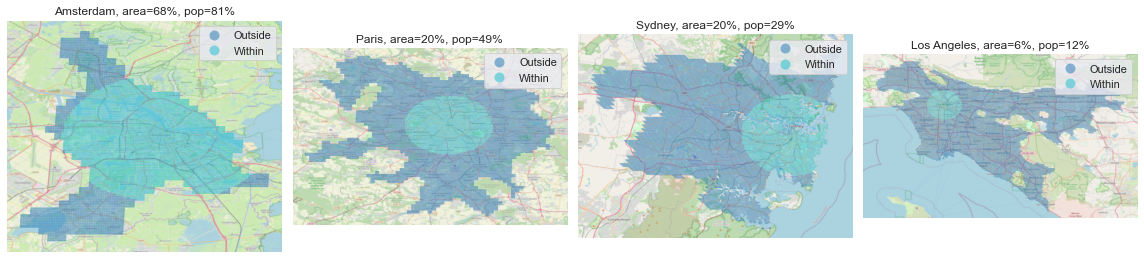

In [7]:
cities = ['Amsterdam', 'Paris', 'Sydney', 'Los Angeles']
city_list_sel = city_list_df.set_index('city').loc[cities].reset_index()

fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=(16, 4), )
axs = axs.flatten()

i = 0
for city in tqdm(city_list_sel.itertuples(), total=len(city_list_sel)):

    # Start working on current city:
    gdf_tt = pd.read_pickle(
        os.path.join(DROOT, '3-interim/populationmasks', city.city + '.pcl'))

    # Get city UTM (meter-distance-accurate EPSG-code).
    zone = utm.from_latlon(city.geometry.y, city.geometry.x)[2]
    utm_epsg = f"326{zone:02d}" if city.geometry.y >= 0 else f"327{zone:02d}"

    # Set both GeoDataFrames to correct CRS.
    townhall = city_list_df[city_list_df.city == city.city]
    th_geometry = townhall.to_crs(epsg=utm_epsg).iloc[0].geometry
    gdf_tt = gdf_tt.to_crs(epsg=utm_epsg)

    # Declare townhall_geometry as destination.
    gdf_tt['sky_d'] = gdf_tt.distance(th_geometry) / 1000
    gdf_tt.loc[gdf_tt.sky_d <= 10, 'inradius'] = 'Within'
    gdf_tt.loc[gdf_tt.sky_d > 10, 'inradius'] = 'Outside'
    gdf_tt = gdf_tt.to_crs(epsg=4326)

    gdf_tt.plot(column='inradius', alpha=0.5, lw=0, ax=axs[i], legend=True)
    ctx.add_basemap(
        axs[i], crs=gdf_tt.crs, source=CTX_PROVIDER, attribution=False)
    
    area = int(round(
        (gdf_tt.inradius == "Within").sum()
        / len(gdf_tt) * 100))
    
    pop = int(round(
        gdf_tt[gdf_tt.inradius == "Within"].cell_pop.sum()
        / gdf_tt.cell_pop.sum()
        * 100))
    
    axs[i].set_title(f"{city.city}, area={area:.0f}%, pop={pop:.0f}%")
    axs[i].axis('off')

    i += 1

fig.savefig(os.path.join(DROOT, '5-graphs', 'cover-part-cities.png'))

/Users/ivo/opt/anaconda3/envs/thesis-env/lib/python3.7/site-packages/contextily/tile.py:580: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


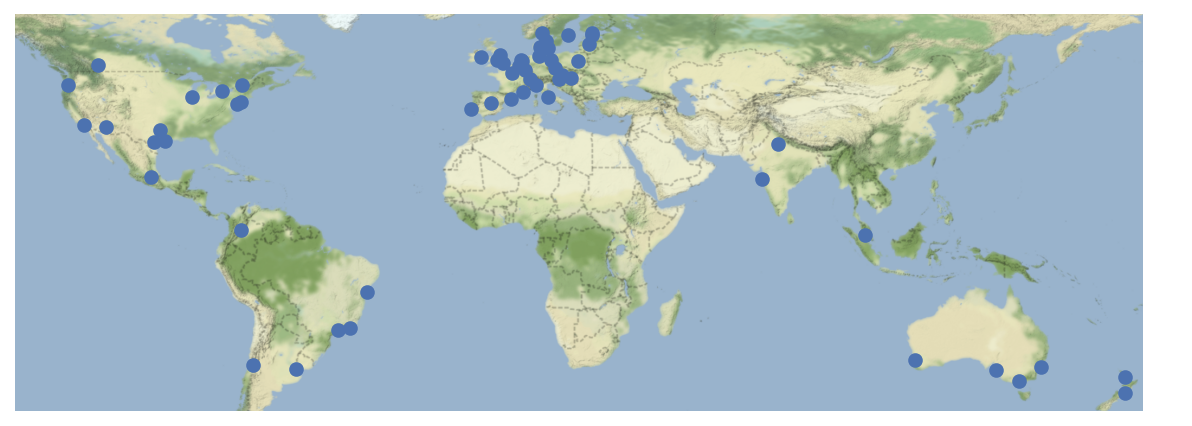

In [115]:
fig, ax = plt.subplots(figsize=(10,10), dpi=150)
city_list_df.plot(ax=ax)
ax.axis('off')
ctx.add_basemap(
    ax, crs=city_list_df.crs, source=ctx.providers.Stamen.TerrainBackground, attribution=False)